In [1]:
from sklearn.model_selection import train_test_split
import pandas as pd
from __future__ import print_function

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import Embedding
from keras.layers import Conv1D, GlobalMaxPooling1D
from keras.datasets import imdb

from keras.layers import LSTM

Using TensorFlow backend.


In [51]:
# set parameters:

batch_size = 32
embedding_dims = 50
filters = 250
kernel_size = 3
hidden_dims = 250

print('Loading data...')
dataset = pd.read_csv('CYP1A2_fixpka.smi', sep= ' ', header=None)
X_SMILES, y = dataset.iloc[:,:-1], dataset.iloc[:, -1]

#Library of unique characters. The first element is not used for future padding
char_lib=["ZMY"]

#Find characters of sequences and build a library
for index, SMILESsequence in X_SMILES.iterrows():
    for letter in SMILESsequence[0]:
        if not letter in char_lib:
            
            char_lib.append(letter)
#print(char_lib)

X=[]
#SMILES sequence to an array
for index, SMILESsequence in X_SMILES.iterrows():
    sequenceArray=[]
    for letter in SMILESsequence[0]:
        sequenceArray.append(char_lib.index(letter))
    X.append(sequenceArray)
    

X=sequence.pad_sequences(X)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=524)

#X_train=X
#y_train=y

print('data loaded')

max_features = X_train.shape[1]
maxlen = X_train.shape[1]

Loading data...
data loaded


In [3]:
print(X_train.shape)

(14903, 226)


In [48]:
model = Sequential()

# we start off with an efficient embedding layer which maps
# our vocab indices into embedding_dims dimensions
model.add(Embedding(max_features,
                    embedding_dims,
                    input_length=maxlen))
model.add(Dropout(0.2))

# we add a Convolution1D, which will learn filters
# word group filters of size filter_length:
model.add(Conv1D(filters=1000,
                 kernel_size=3,
                 padding='valid',
                 activation='relu',
                 strides=1))

# we use max pooling:
model.add(GlobalMaxPooling1D())



# We add a vanilla hidden layer:
model.add(Dense(hidden_dims))
model.add(Dropout(0.2))


model.add(Activation('relu'))

# We project onto a single unit output layer, and squash it with a sigmoid:
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [52]:
model.fit(X_train, y_train,
          batch_size=100,
          epochs=100,
          validation_split=0.2)

Train on 9537 samples, validate on 2385 samples
Epoch 1/100
9537/9537 [==============================] - 4s - loss: 0.3475 - acc: 0.8526 - val_loss: 0.2882 - val_acc: 0.8885
Epoch 2/100
9537/9537 [==============================] - 4s - loss: 0.3261 - acc: 0.8583 - val_loss: 0.3268 - val_acc: 0.8658
Epoch 3/100
9537/9537 [==============================] - 4s - loss: 0.3272 - acc: 0.8595 - val_loss: 0.2966 - val_acc: 0.8767
Epoch 4/100
9537/9537 [==============================] - 4s - loss: 0.3153 - acc: 0.8627 - val_loss: 0.3035 - val_acc: 0.8713
Epoch 5/100
9537/9537 [==============================] - 4s - loss: 0.3139 - acc: 0.8600 - val_loss: 0.3256 - val_acc: 0.8667
Epoch 6/100
9537/9537 [==============================] - 4s - loss: 0.3060 - acc: 0.8686 - val_loss: 0.3157 - val_acc: 0.8704
Epoch 7/100
9537/9537 [==============================] - 4s - loss: 0.2929 - acc: 0.8748 - val_loss: 0.3466 - val_acc: 0.8516
Epoch 8/100
9537/9537 [==============================] - 4s - loss: 0.

9537/9537 [==============================] - 4s - loss: 0.1641 - acc: 0.9308 - val_loss: 0.5466 - val_acc: 0.8323
Epoch 66/100
9537/9537 [==============================] - 4s - loss: 0.1791 - acc: 0.9273 - val_loss: 0.5231 - val_acc: 0.8340
Epoch 67/100
9537/9537 [==============================] - 4s - loss: 0.1734 - acc: 0.9270 - val_loss: 0.5086 - val_acc: 0.8289
Epoch 68/100
9537/9537 [==============================] - 4s - loss: 0.1759 - acc: 0.9232 - val_loss: 0.5507 - val_acc: 0.8298
Epoch 69/100
9537/9537 [==============================] - 4s - loss: 0.1750 - acc: 0.9273 - val_loss: 0.6126 - val_acc: 0.8285
Epoch 70/100
9537/9537 [==============================] - 4s - loss: 0.1668 - acc: 0.9321 - val_loss: 0.6330 - val_acc: 0.8356
Epoch 71/100
9537/9537 [==============================] - 4s - loss: 0.1660 - acc: 0.9289 - val_loss: 0.5382 - val_acc: 0.8302
Epoch 72/100
9537/9537 [==============================] - 4s - loss: 0.1841 - acc: 0.9193 - val_loss: 0.5710 - val_acc: 0.82

In [57]:
y_score=model.predict_proba(X_test)
model.evaluate(X_test, y_test, verbose=0)

2752/2981 [==========================>...] - ETA: 0s

[0.67383242581203373, 0.82220731300221561]

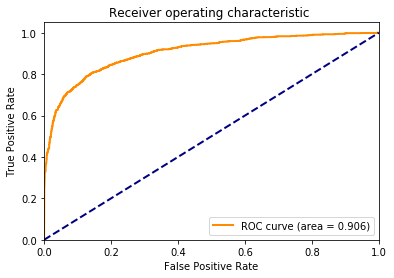

In [55]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc



y_score_get_value=[]
for item in y_score:
    y_score_get_value.append(item[0])
    
fpr, tpr, _ = roc_curve(y_test, y_score_get_value)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.3f)' % auc(fpr,tpr))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic ')
plt.legend(loc="lower right")
plt.show()








In [58]:
from keras.models import load_model
model.save("CYP1A2_conv1.h5")